In [48]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import os
import copy
import shutil
import random
from skimage import io
from skimage.transform import rescale, resize
import skimage.exposure
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def random_brightness(image):
  transform = A.RandomBrightnessContrast(p=0.5)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_rgbshift(image):
  transform = A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_clahe(image):
  clip_limit=6.0
  tile_grid_size=(16, 16)

  transform = A.CLAHE(clip_limit, tile_grid_size, p=1.0)
  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])
  return im

def apply_rotation(image, mask):
  angle = random.randint(0, 90)
  transform = A.Rotate(limit=[angle, angle], p=1.0, border_mode=cv2.BORDER_CONSTANT)

  augmentations = transform(image = image)
  im = Image.fromarray(augmentations['image'])

  augmentations = transform(image = mask)
  msk = Image.fromarray(augmentations['image'])

  return im, msk

def read_tiff(img_path, resize_ratio=None, resizing = True, normalize=True, printing=True):
  img = io.imread(img_path)
  img_F =img.copy()
  if resize_ratio:
    img_F = rescale(img, resize_ratio, anti_aliasing=True)
  if resizing:
    img_F = resize(img_F, (750,750), anti_aliasing=True)
  
  path_img = os.path.basename(img_path)
  if normalize:
    CHANNELS = range(12)
    img_F = np.dstack([
        skimage.exposure.rescale_intensity(img_F[:,:,c], out_range=(0, 1)) 
        for c in CHANNELS])
  if printing:
    print(f"(origin shape: {path_img}: {img.shape} -> rescale: {str(img_F.shape)}) - Range -> [{img_F.min(), img_F.max()}]")
  return img_F

In [49]:
root = "/home/sebasmos/Desktop/DATASETS/"
code = 23001
baseline = os.path.join(root, "DATASET_improved_10_cities", str(code))
# Path to dataset with improved images
aug_root =  os.path.join(root, "DATASET_augmented",  str(code))
print(f"root: ", root)
print(f"baseline: ", baseline)
print(f"aug_root: ", aug_root)
CLEAN = False
if CLEAN:
    shutil.rmtree(aug_root)
else: 
    try:
        shutil.copytree(baseline, aug_root)
    except:
        pass

root:  /home/sebasmos/Desktop/DATASETS/
baseline:  /home/sebasmos/Desktop/DATASETS/DATASET_improved_10_cities/23001
aug_root:  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001


In [50]:
images = glob.glob(os.path.join(baseline)+"/*.tiff")
print(f"Total # images: ", len(images))

Total # images:  165


In [51]:
def augment_satellite_image(path, display=True, resize_ratio=(1, 1, 1)):
        """
        Augment images given image path 
        https://albumentations.ai/docs/getting_started/image_augmentation/?query=RandomBrightnessContrast
        ::param path: image path
        """
        count = 1
        count2 = 1
        count3 = 1
        image_name = path.split("/")[-1][:-5]
        img = (255*read_tiff(path, resize_ratio=resize_ratio, resizing = True, normalize=True, printing=True)).astype("uint8")
        B =img[:,:,1:4][:,:,0]
        G =img[:,:,1:4][:,:,1]
        R =img[:,:,1:4][:,:,2]
        RGB_img = np.stack([R,G,B]).transpose(2,1,0)

        # RGBSHIFT
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_rgbshift(RGB_img))
            aug_path = os.path.join(aug_root, image_name + "_A1_"+str(count)+".tiff")
            print("storing ", aug_path)
            io.imsave(aug_path, img)
            count+=1
        # CLAHE
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(apply_clahe(RGB_img))
            aug_path = os.path.join(aug_root, image_name+ "_A2_"+str(count2)+".tiff")
            print("storing ", aug_path)
            io.imsave(aug_path, img)
            count2+=1
        #random_brightness
        if random.random() > 0.5:
            img[:,:,1:4] = np.array(random_brightness(RGB_img))
            aug_path = os.path.join(aug_root, image_name+ "_A3_"+str(count2)+".tiff")
            print("Image augmented and stored in: ", aug_path)
            io.imsave(aug_path, img)
            count3+=1
        if display:
            plt.figure(figsize=(9, 3))
            print(img[:,:,1:4].shape)
            plt.imshow(RGB_img)

(origin shape: image_2018-04-29.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
storing  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2018-04-29_A1_1.tiff
storing  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2018-04-29_A2_1.tiff
Image augmented and stored in:  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2018-04-29_A3_2.tiff
(750, 750, 3)
(origin shape: image_2017-08-13.tiff: (747, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
Image augmented and stored in:  /home/sebasmos/Desktop/DATASETS/DATASET_augmented/23001/image_2017-08-13_A3_1.tiff
(750, 750, 3)


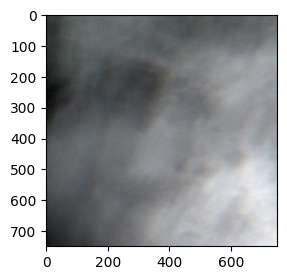

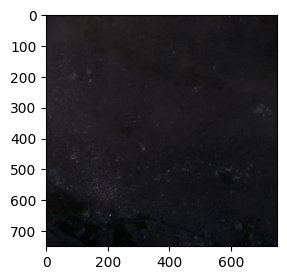

In [52]:
for idx, path in enumerate(images):
    augment_satellite_image(images[idx])
    if idx==1:
        break

### Improving satellite imagery 
Find the closest image sideways under threshold, apply transformation and replace. 

In [58]:
def find_closest_temporal_neighbor(path, images, threshold):
    upward = 0
    backward = 0
    current_idx = images.index(path)
    rest = len(images)-current_idx
    while upward<=(len(images)-current_idx):
        img = read_tiff(images[upward], resize_ratio=(1, 1, 1), resizing = True, normalize=True, printing=True)
        upward+=1
        if np.sum(img)>threshold:
                neighborUp = path
                break
    while downward<=(current_idx) and current_idx!=0:
        img = read_tiff(images[downward], resize_ratio=(1, 1, 1), resizing = True, normalize=True, printing=True)
        downward+=1
        if np.sum(img)>threshold:
                neighborDown = path
                break
    if upward>backward:
        return neighborUp
    else:
        return neighborDown

In [60]:
resize_ratio=(1, 1, 1)
count = 0
threshold = 10
neighbor = ""
for path in sorted(images):
    img = read_tiff(path, resize_ratio=resize_ratio, resizing = True, normalize=True, printing=True)
    print(count, np.sum(img))
    if np.sum(img)<threshold:
        print(f"Image f was empty and was replaced with augmentation")
        # if image content is lower than threshold, replace 
        find_closest_temporal_neighbor(path, images, threshold)
    print("ended ")
    count+=1
    if count==2:
        break

(origin shape: image_2015-11-01.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 0.0)]
0 0.0
Image f was empty and was replaced with augmentation
(origin shape: image_2018-04-29.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2018-04-29.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
ended 
(origin shape: image_2015-11-08.tiff: (747, 745, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 0.0)]
1 0.0
Image f was empty and was replaced with augmentation
(origin shape: image_2018-04-29.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
(origin shape: image_2018-04-29.tiff: (746, 746, 12) -> rescale: (750, 750, 12)) - Range -> [(0.0, 1.0)]
ended 
